In [122]:
import re
import pandas as pd
import matplotlib.pyplot as plt

In [123]:
class resultado:
    def __init__(self):
        self.command = None
        self.memory = None
        self.perf = []
        self.energy = []
    
    def __str__(self):
        return "command: " + self.command + "\nmemory: " + str(self.memory) + "\nperf:\n" + str(self.perf) + "\nenergy:\n" + str(self.energy)

    # obtiene la media del tiempo y energia de ejecucion de un comando
    def avgTime(self):
        return sum([x['perf_stats']['time_elapsed'] for x in self.perf]) / len(self.perf)
    
    def avgEnergy(self):
        return sum([x['energy']['energy_pkg'] for x in self.energy]) / len(self.energy)
    
    # obtiene la desviación estándar del tiempo y energia de ejecucion de un comando
    def stdTime(self):
        avg = self.avgTime()
        return (sum([(x['perf_stats']['time_elapsed'] - avg) ** 2 for x in self.perf]) / len(self.perf)) ** 0.5
    
    def stdEnergy(self):
        avg = self.avgEnergy()
        return (sum([(x['energy']['energy_pkg'] - avg) ** 2 for x in self.energy]) / len(self.energy)) ** 0.5
    
    def avgPerfStats(self):
        context_switches = sum([x['perf_stats']['context-switches'] for x in self.perf]) / len(self.perf)
        cycles = sum([x['perf_stats']['cycles'] for x in self.perf]) / len(self.perf)
        instructions = sum([x['perf_stats']['instructions'] for x in self.perf]) / len(self.perf)
        cache_references = sum([x['perf_stats']['cache-references'] for x in self.perf]) / len(self.perf)
        cache_misses = sum([x['perf_stats']['cache-misses'] for x in self.perf]) / len(self.perf)
        branches = sum([x['perf_stats']['branches'] for x in self.perf]) / len(self.perf)
        branch_misses = sum([x['perf_stats']['branch-misses'] for x in self.perf]) / len(self.perf)
        
        return {'context_switches': context_switches, 
                'cycles': cycles, 
                'instructions': instructions, 
                'cache_references': cache_references, 
                'cache_misses': cache_misses, 
                'branches': branches, 
                'branch_misses': branch_misses}

    
def findResult(list:list, command:str)->resultado:
    for i in list:
        if i.command == command:
            return i
    return None

In [124]:
def parseMemory(line):
    """ match = re.search(r'Memoria util de la ejecucion: (.+)', line)
    return match.group(1) if match else None """
    
    if 'Maximum resident set size (kbytes): ' in line:
        memory = int(line.split(':')[1])
    return memory

def parsePerfStats(lines):
    stats = {}
    for line in lines:
        if 'context-switches' in line:
            stats['context-switches'] = int(line.split()[0].replace('.', ''))
        elif 'cycles' in line:
            stats['cycles'] = int(line.split()[0].replace('.', ''))
        elif 'instructions' in line:
            stats['instructions'] = int(line.split()[0].replace('.', ''))
        elif 'cache-references' in line:
            stats['cache-references'] = int(line.split()[0].replace('.', ''))
        elif 'cache-misses' in line:
            stats['cache-misses'] = int(line.split()[0].replace('.', ''))
        elif 'branch-misses' in line:
            # la linea de branch-misses contiene branches, por lo que esta va primero
            stats['branch-misses'] = int(line.split()[0].replace('.', ''))
        elif 'branches' in line:
            stats['branches'] = int(line.split()[0].replace('.', ''))
        elif 'seconds time elapsed' in line:
            stats['time_elapsed'] = float(line.split()[0].replace(',', '.'))
    return stats

def parseEnergy(lines):
    energy_stats = {}
    for line in lines:
        if 'power/energy-pkg/' in line:
            energy_stats['energy_pkg'] = float(line.split()[0].replace('.', '').replace(',', '.'))
        elif 'power/energy-cores/' in line:
            energy_stats['energy_cores'] = float(line.split()[0].replace('.', '').replace(',', '.'))
        elif 'power/energy-gpu/' in line:
            energy_stats['energy_gpu'] = float(line.split()[0].replace('.', '').replace(',', '.'))
    return energy_stats

In [125]:

def parse_file(filename):
    results = []
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    i = 0
    while i < len(lines):
        line = lines[i]
        
        if line.startswith("Memoria de la ejecucion:"):
            result = resultado()
            result.command = line.split("Memoria de la ejecucion: ")[1].strip()
            i += 1
            result.memory = parseMemory(lines[i])
            results.append(result)
        
        if line.startswith("Ejecutando "):
            command = line.split("Ejecutando ")[1].strip()
            result = findResult(results, command)
            """
            if result is None:
                result = resultado()
                result.command = command
                results.append(result)
            """
            
            perf_stats_lines = []
            while i < len(lines) and not lines[i].startswith('-----------------------------------'):
                perf_stats_lines.append(lines[i].strip())
                i += 1
            
            exec_info = {
                'perf_stats': parsePerfStats(perf_stats_lines)
            }
            result.perf.append(exec_info)
            
        
        elif line.startswith("Consumo de energia "):
            command = line.split("Consumo de energia ")[1].strip()
            result = findResult(results, command)
            
            energy_lines = []
            while i < len(lines) and not lines[i].startswith('-----------------------------------'):
                energy_lines.append(lines[i].strip())
                i += 1
            
            exec_info = {
                'energy': parseEnergy(energy_lines)
            }
            result.energy.append(exec_info)
        
        else:
            i += 1

    return results

In [126]:
def tableMemory(parsed_data, test_name):
    
    ver = ["Version C", "version C++", "Version Java", "Version Python"]
    data = []
    for i, result in enumerate(parsed_data):
        data.append([ver[i], result.memory])
    
    df = pd.DataFrame(data, columns=[test_name,'Memoria (kB)'])
    display(df)

In [127]:
def tablePerfStat(parsed_data, test_name):
    
    ver = ["Version C", "version C++", "Version Java", "Version Python"]
    data = []
    
    for i, result in enumerate(parsed_data):
        avg = result.avgPerfStats()
        ratio_ciclo = avg['cycles'] / avg['instructions'] if avg['instructions'] != 0 else 0
        ratio_cache = avg['cache_misses'] / avg['cache_references'] * 100 if avg['cache_references'] != 0 else 0
        ratio_branches = avg['branch_misses'] / avg['branches'] * 100 if avg['branches'] != 0 else 0
        data.append([
            ver[i], avg['context_switches'], avg['cycles'], avg['instructions'],ratio_ciclo,
            avg['cache_references'], avg['cache_misses'], ratio_cache, avg['branches'], avg['branch_misses'], ratio_branches
        ])
        
    df = pd.DataFrame(data, columns=[
        test_name, 'context-switches', 'cycles', 'instructions', 'CPI', 'cache-references', 
        'cache-misses', 'ratio cache %', 'branches', 'branch-misses', 'ratio branches %'
    ])
    pd.set_option('display.float_format', '{:.2f}'.format)
    display(df)

In [128]:
def plotTime(parsed_data, test_name):
    
    avg = [result.avgTime() for result in parsed_data]
    std = [result.stdTime() for result in parsed_data]
    # cmd = [result.command for result in parsed_data]
    ver = ["Version C", "version C++", "Version Java", "Version Python"]

    plt.figure(figsize=(10, 5))
    plt.bar(ver, avg, yerr=std, capsize=6, ecolor='red', width=0.4)
    
    for i in range(len(avg)):
        plt.annotate(f'{avg[i]:.2f}', (ver[i], avg[i]), textcoords="offset points", xytext=(0,5), ha='center')

    plt.xlabel('Versiones')
    plt.ylabel('Tiempo (s)')
    plt.title('Resultados del tiempo de ejecucion de ' + test_name)

    plt.show()

In [129]:
def plotEnergy(parsed_data, test_name):
    
    avg = [result.avgEnergy() for result in parsed_data]
    std = [result.stdEnergy() for result in parsed_data]
    # cmd = [result.command for result in parsed_data]
    ver = ["Version C", "version C++", "Version Java", "Version Python"]

    plt.figure(figsize=(10, 5))
    plt.bar(ver, avg, yerr=std, capsize=6, ecolor='red', width=0.4)

    for i in range(len(avg)):
        plt.annotate(f'{avg[i]:.2f}', (ver[i], avg[i]), textcoords="offset points", xytext=(0,5), ha='center')

    plt.xlabel('Versiones')
    plt.ylabel('Energia (J)')
    plt.title('Resultados del consumo energetico de ' + test_name)

    plt.show()

In [130]:
def tableMetrics(parsed_data):
    
    commands = [result.command for result in parsed_data]
    memory = [result.memory for result in parsed_data]
    avg_time = [result.avgTime() for result in parsed_data]
    avg_energy = [result.avgEnergy() for result in parsed_data]

    memory_first = memory[0]
    avg_time_first = avg_time[0]
    avg_energy_first = avg_energy[0]

    memory_ratios = [mem / memory_first if memory_first != 0 else 0 for mem in memory]
    avg_time_ratios = [time / avg_time_first if avg_time_first != 0 else 0 for time in avg_time]
    avg_energy_ratios = [energy / avg_energy_first if avg_energy_first != 0 else 0 for energy in avg_energy]

    data = {
        'Memoria (kB)': memory,
        'Memoria Ratio': memory_ratios,
        'Tiempo (s)': avg_time,
        'Tiempo Ratio': avg_time_ratios,
        'Energía (J)': avg_energy,
        'Energía Ratio': avg_energy_ratios
    }
    
    df = pd.DataFrame(data, index=commands)
    pd.set_option('display.float_format', '{:.2f}'.format)
    display(df)

,Bucle,Memoria (kB)
0,Version C,1152
1,version C++,1152
2,Version Java,39864
3,Version Python,8064


,Bucle,context-switches,cycles,instructions,CPI,cache-references,cache-misses,ratio cache %,branches,branch-misses,ratio branches %
0,Version C,0.60,565088952.80,300126932.60,1.88,86475.80,18440.80,21.32,100332988.40,2206.40,0.00
1,version C++,9.20,557601893.60,300802782.20,1.85,91131.00,16710.80,18.34,100182439.20,2565.20,0.00
2,Version Java,120.60,118616296.80,140132463.40,0.85,6662714.00,1546944.40,23.22,26177861.00,675537.40,2.58
3,Version Python,13.00,8812924540.00,36263242084.80,0.24,2747800.20,278480.20,10.13,7206153602.00,384197.00,0.01


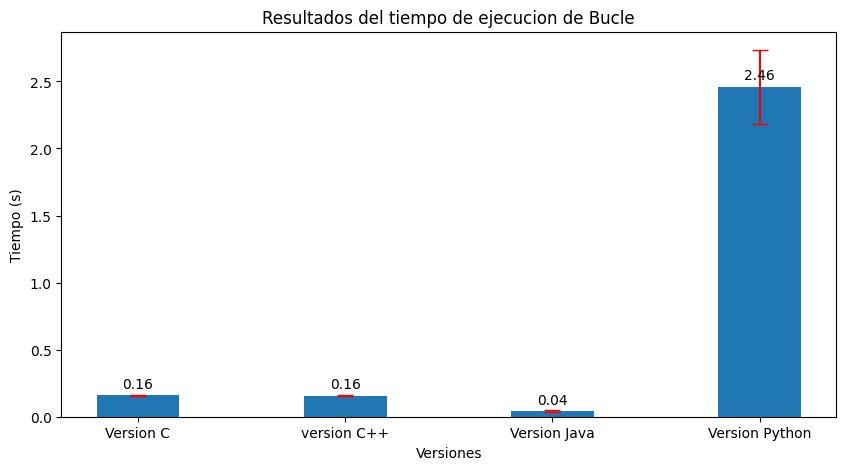

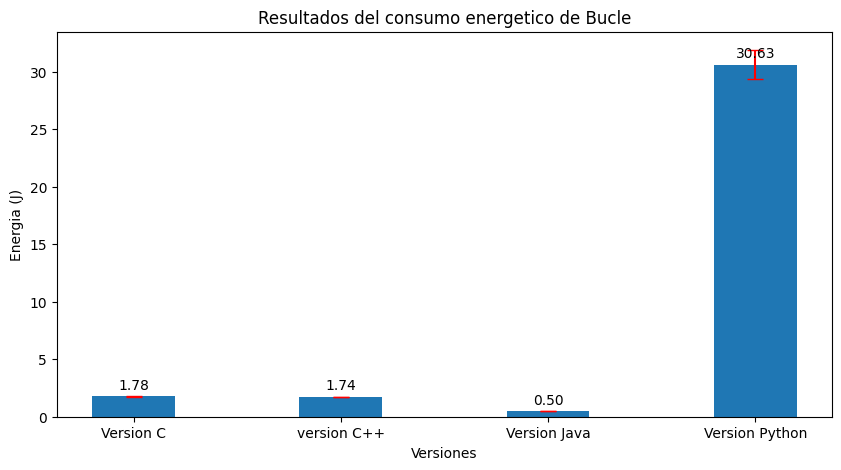

,Memoria (kB),Memoria Ratio,Tiempo (s),Tiempo Ratio,Energía (J),Energía Ratio
./bucle_c,1152,1.00,0.16,1.00,1.78,1.00
./bucle_cpp,1152,1.00,0.16,0.98,1.74,0.98
java -jar bucle_java.jar,39864,34.60,0.04,0.25,0.50,0.28
python3 bucle.py,8064,7.00,2.46,15.46,30.63,17.21


In [131]:
filename = 'build/analisis_basico/bucle/output.txt' 
parsed_data = parse_file(filename)

tableMemory(parsed_data, "Bucle")
tablePerfStat(parsed_data, "Bucle")
plotTime(parsed_data, "Bucle")
plotEnergy(parsed_data, "Bucle")
tableMetrics(parsed_data)

,Aleatorio,Memoria (kB)
0,Version C,1280
1,version C++,3456
2,Version Java,40120
3,Version Python,8832


,Aleatorio,context-switches,cycles,instructions,CPI,cache-references,cache-misses,ratio cache %,branches,branch-misses,ratio branches %
0,Version C,9.60,5502349661.80,7589307359.80,0.73,132688.60,26609.80,20.05,1690804719.00,3231846.40,0.19
1,version C++,15.20,10327379403.60,18962374147.60,0.54,327486.40,65622.20,20.04,2252213286.20,50758662.60,2.25
2,Version Java,161.60,3646495114.00,3177080445.20,1.15,8205278.60,1549067.40,18.88,331476531.00,936007.80,0.28
3,Version Python,408.80,221240511024.40,692903204970.40,0.32,10212536.40,490572.80,4.80,126511922749.80,6015361.20,0.00


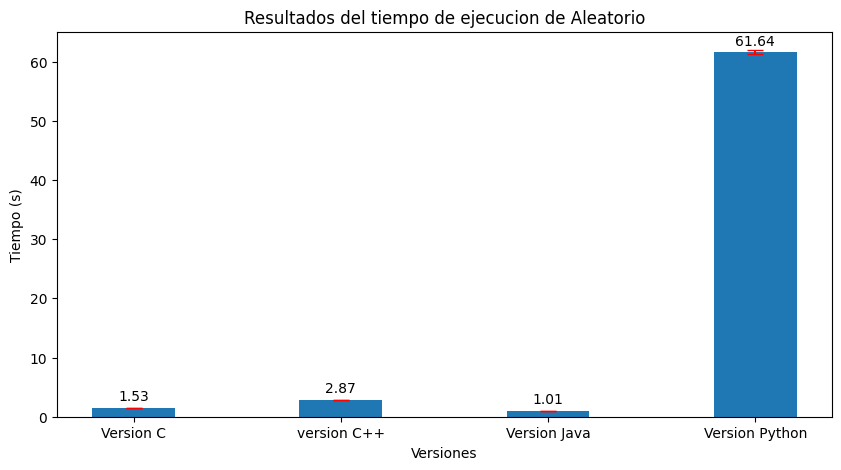

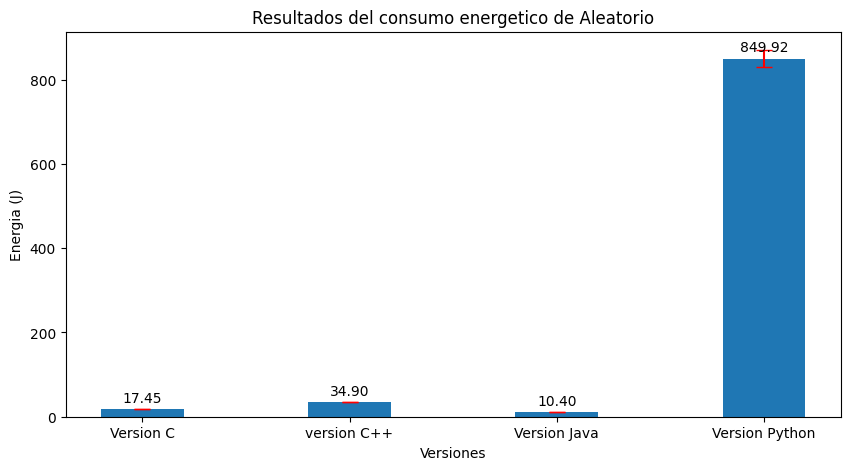

,Memoria (kB),Memoria Ratio,Tiempo (s),Tiempo Ratio,Energía (J),Energía Ratio
./aleatorio_c,1280,1.00,1.53,1.00,17.45,1.00
./aleatorio_cpp,3456,2.70,2.87,1.87,34.90,2.00
java -jar aleatorio_java.jar,40120,31.34,1.01,0.66,10.40,0.60
python3 aleatorio.py,8832,6.90,61.64,40.17,849.92,48.69


In [132]:
filename = 'build/analisis_basico/aleatorio/output.txt' 
parsed_data = parse_file(filename)

tableMemory(parsed_data, "Aleatorio")
tablePerfStat(parsed_data, "Aleatorio")
plotTime(parsed_data, "Aleatorio")
plotEnergy(parsed_data, "Aleatorio")
tableMetrics(parsed_data)

,Array,Memoria (kB)
0,Version C,118272
1,version C++,120192
2,Version Java,159672
3,Version Python,1183616


,Array,context-switches,cycles,instructions,CPI,cache-references,cache-misses,ratio cache %,branches,branch-misses,ratio branches %
0,Version C,0.80,475485011.40,688829867.80,0.69,11697792.60,8107051.60,69.30,66935947.40,22800.00,0.03
1,version C++,1.60,476374469.60,692033493.20,0.69,11656367.60,8129979.40,69.75,67712028.20,22459.80,0.03
2,Version Java,242.00,494149953.00,634990768.40,0.78,23034191.80,9587453.60,41.62,111751040.20,2017605.20,1.81
3,Version Python,23.40,8986818889.00,31477861088.20,0.29,130335934.60,88396716.20,67.82,5699445690.80,912942.20,0.02


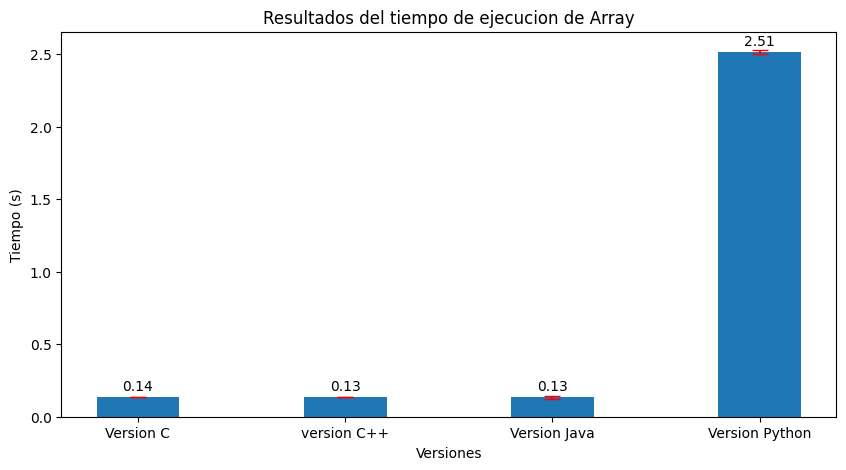

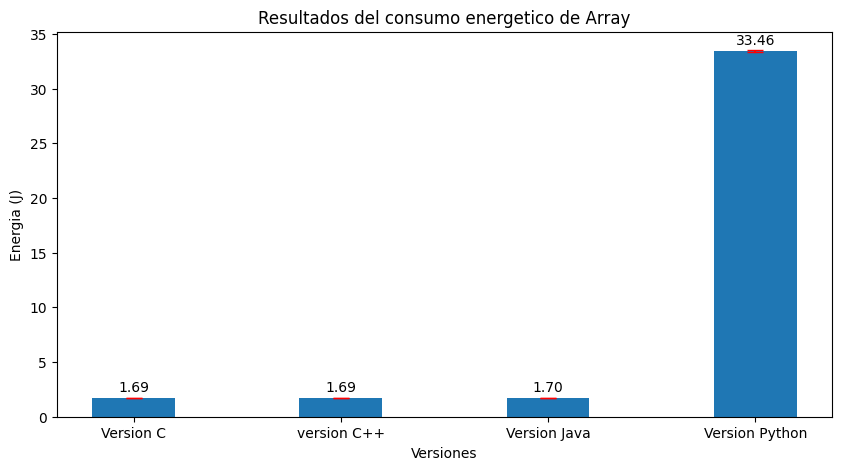

,Memoria (kB),Memoria Ratio,Tiempo (s),Tiempo Ratio,Energía (J),Energía Ratio
./array_c,118272,1.00,0.14,1.00,1.69,1.00
./array_cpp,120192,1.02,0.13,0.99,1.69,1.00
java -jar array_java.jar,159672,1.35,0.13,0.99,1.70,1.00
python3 array.py,1183616,10.01,2.51,18.55,33.46,19.75


In [133]:
filename = 'build/analisis_basico/array/output.txt' 
parsed_data = parse_file(filename)

tableMemory(parsed_data, "Array")
tablePerfStat(parsed_data, "Array")
plotTime(parsed_data, "Array")
plotEnergy(parsed_data, "Array")
tableMetrics(parsed_data)

,If 3,Memoria (kB)
0,Version C,40320
1,version C++,42112
2,Version Java,156216
3,Version Python,439296


,If 3,context-switches,cycles,instructions,CPI,cache-references,cache-misses,ratio cache %,branches,branch-misses,ratio branches %
0,Version C,1.00,150923371.80,291395895.40,0.52,3702171.60,2594550.20,70.08,18749070.40,12640.20,0.07
1,version C++,0.40,153811746.20,296040979.60,0.52,3677565.00,2634830.00,71.65,19157474.20,12673.60,0.07
2,Version Java,156.40,434060130.80,485814404.40,0.89,17816206.80,6415237.00,36.01,101009549.20,1573607.00,1.56
3,Version Python,18.00,13025597028.80,40378078502.80,0.32,96224778.20,59624443.00,61.96,7692379773.40,10278414.80,0.13


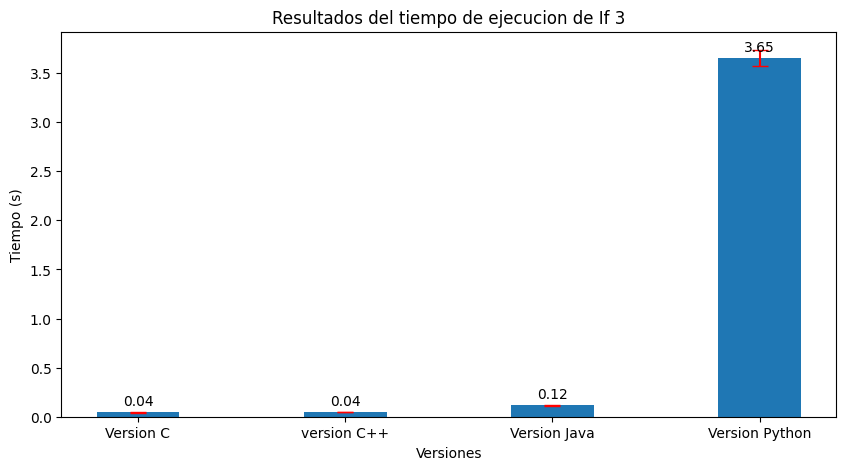

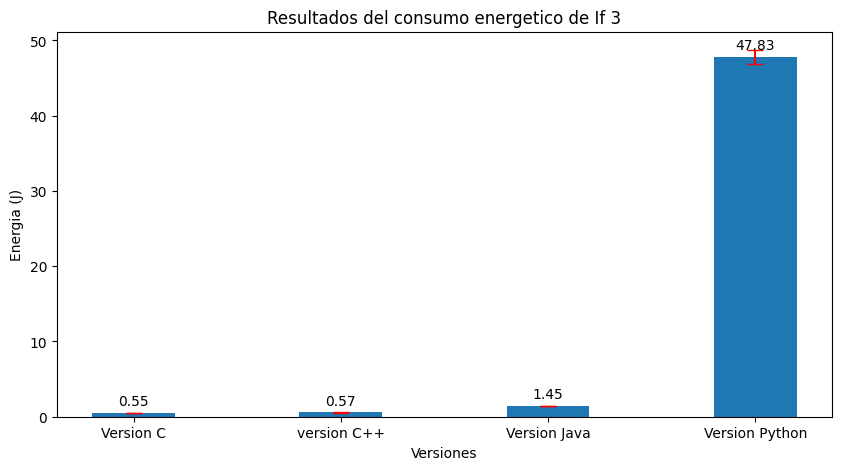

,Memoria (kB),Memoria Ratio,Tiempo (s),Tiempo Ratio,Energía (J),Energía Ratio
./if_case_3_c,40320,1.00,0.04,1.00,0.55,1.00
./if_case_3_cpp,42112,1.04,0.04,0.99,0.57,1.04
java -jar if_case_3_java.jar,156216,3.87,0.12,2.60,1.45,2.65
python3 if_case_3.py,439296,10.90,3.65,81.25,47.83,87.27


In [134]:
filename = 'build/analisis_basico/condicionales/if_case_3/output.txt' 
parsed_data = parse_file(filename)

tableMemory(parsed_data, "If 3")
tablePerfStat(parsed_data, "If 3")
plotTime(parsed_data, "If 3")
plotEnergy(parsed_data, "If 3")
tableMetrics(parsed_data)

,If 10,Memoria (kB)
0,Version C,40448
1,version C++,42112
2,Version Java,156348
3,Version Python,439296


,If 10,context-switches,cycles,instructions,CPI,cache-references,cache-misses,ratio cache %,branches,branch-misses,ratio branches %
0,Version C,0.80,159216190.20,313311136.00,0.51,3614018.00,2596607.20,71.85,18823377.20,10400.20,0.06
1,version C++,2.60,161366767.00,316717869.60,0.51,3763687.40,2710176.60,72.01,19318874.60,12379.60,0.06
2,Version Java,141.40,447816699.00,524648088.00,0.85,18823511.00,6681119.00,35.49,102037183.40,1720419.80,1.69
3,Version Python,41.60,15686516155.00,51219028678.80,0.31,96456813.60,60237530.00,62.45,9680903644.20,13848682.60,0.14


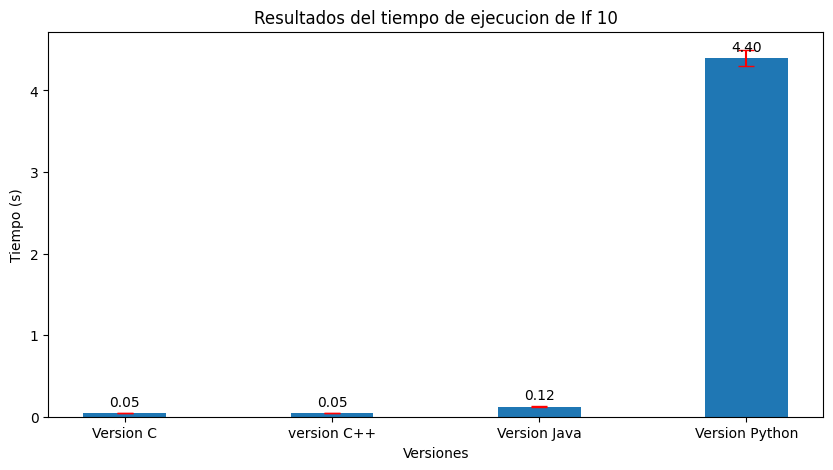

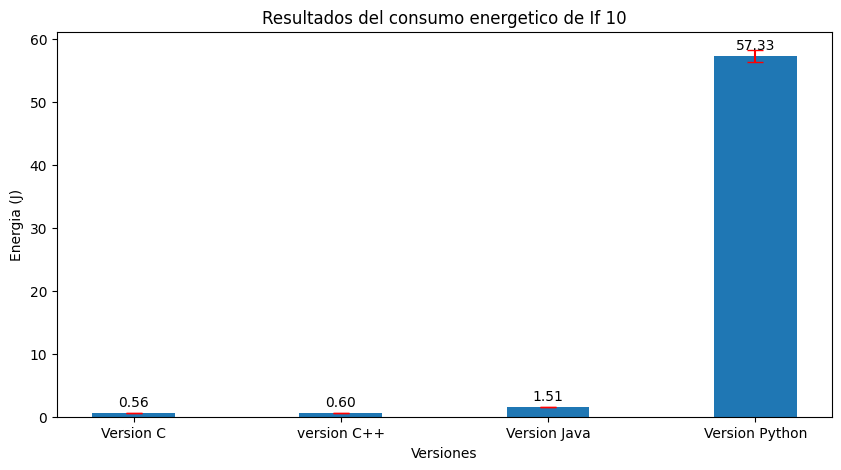

,Memoria (kB),Memoria Ratio,Tiempo (s),Tiempo Ratio,Energía (J),Energía Ratio
./if_case_10_c,40448,1.00,0.05,1.00,0.56,1.00
./if_case_10_cpp,42112,1.04,0.05,1.00,0.60,1.06
java -jar if_case_10_java.jar,156348,3.87,0.12,2.66,1.51,2.68
python3 if_case_10.py,439296,10.86,4.40,93.83,57.33,101.65


In [135]:
filename = 'build/analisis_basico/condicionales/if_case_10/output.txt' 
parsed_data = parse_file(filename)

tableMemory(parsed_data, "If 10")
tablePerfStat(parsed_data, "If 10")
plotTime(parsed_data, "If 10")
plotEnergy(parsed_data, "If 10")
tableMetrics(parsed_data)

,If 1000,Memoria (kB)
0,Version C,40320
1,version C++,42112
2,Version Java,156604
3,Version Python,442624


,If 1000,context-switches,cycles,instructions,CPI,cache-references,cache-misses,ratio cache %,branches,branch-misses,ratio branches %
0,Version C,1.20,149120836.00,280937519.20,0.53,3724820.80,2633885.40,70.71,18490877.20,12265.00,0.07
1,version C++,1.40,152179582.20,285157632.80,0.53,3745586.40,2655599.60,70.90,19301104.80,13109.80,0.07
2,Version Java,802.80,69386210934.60,204172326397.40,0.34,37368227.00,7706400.80,20.62,35385907735.00,24330374.80,0.07
3,Version Python,3296.40,412899431668.60,1688396429059.80,0.24,266747039.20,59202459.60,22.19,308033214454.80,71028899.80,0.02


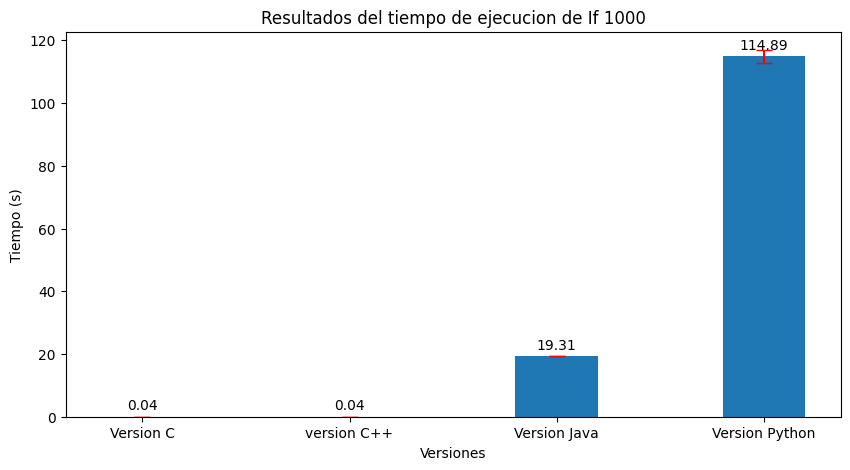

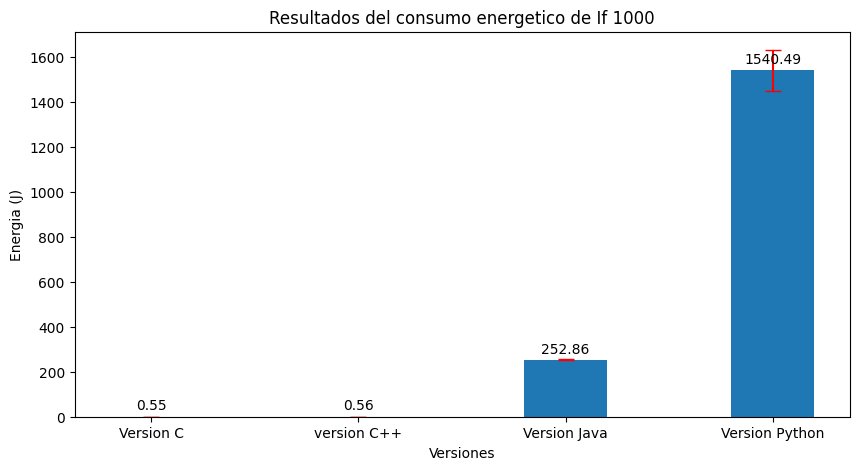

,Memoria (kB),Memoria Ratio,Tiempo (s),Tiempo Ratio,Energía (J),Energía Ratio
./if_case_1000_c,40320,1.00,0.04,1.00,0.55,1.00
./if_case_1000_cpp,42112,1.04,0.04,0.99,0.56,1.00
java -jar if_case_1000_java.jar,156604,3.88,19.31,433.74,252.86,456.42
python3 if_case_1000.py,442624,10.98,114.89,2580.21,1540.49,2780.67


In [136]:
filename = 'build/analisis_basico/condicionales/if_case_1000/output.txt' 
parsed_data = parse_file(filename)

tableMemory(parsed_data, "If 1000")
tablePerfStat(parsed_data, "If 1000")
plotTime(parsed_data, "If 1000")
plotEnergy(parsed_data, "If 1000")
tableMetrics(parsed_data)

,Switch 3,Memoria (kB)
0,Version C,40320
1,version C++,42112
2,Version Java,156476
3,Version Python,439552


,Switch 3,context-switches,cycles,instructions,CPI,cache-references,cache-misses,ratio cache %,branches,branch-misses,ratio branches %
0,Version C,0.80,526394330.00,355633870.20,1.48,3663511.40,2637102.00,71.98,53343736.60,6944561.00,13.02
1,version C++,1.00,524332935.00,361111733.20,1.45,3731478.20,2690902.80,72.11,53993193.00,7239749.40,13.41
2,Version Java,166.40,667478766.60,641067109.60,1.04,19124901.00,7898543.20,41.30,120836404.20,8655240.00,7.16
3,Version Python,19.00,12804716193.20,39492867088.60,0.32,96770662.80,59433082.40,61.42,7498352129.80,8602485.00,0.11


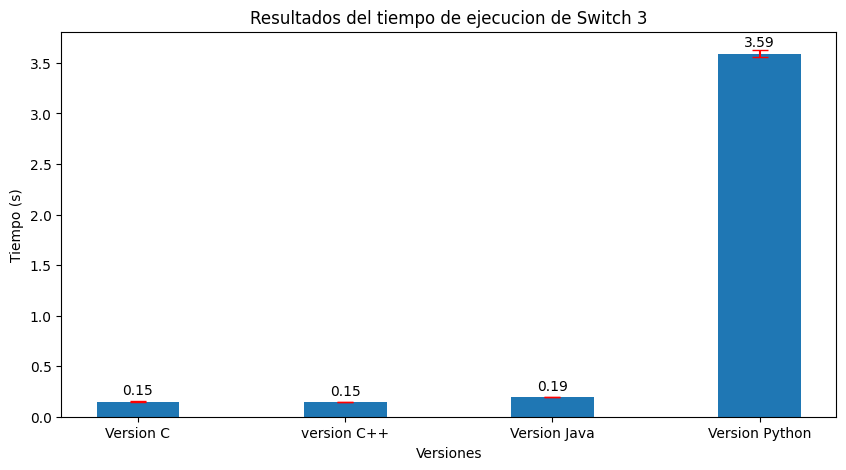

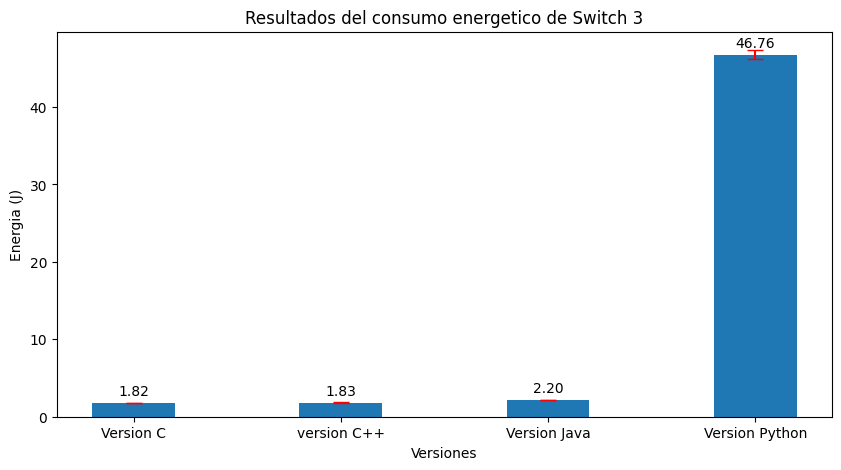

,Memoria (kB),Memoria Ratio,Tiempo (s),Tiempo Ratio,Energía (J),Energía Ratio
./switch_case_3_c,40320,1.00,0.15,1.00,1.82,1.00
./switch_case_3_cpp,42112,1.04,0.15,0.98,1.83,1.00
java -jar switch_case_3_java.jar,156476,3.88,0.19,1.30,2.20,1.21
python3 switch_case_3.py,439552,10.90,3.59,24.01,46.76,25.72


In [137]:
filename = 'build/analisis_basico/condicionales/switch_case_3/output.txt' 
parsed_data = parse_file(filename)

tableMemory(parsed_data, "Switch 3")
tablePerfStat(parsed_data, "Switch 3")
plotTime(parsed_data, "Switch 3")
plotEnergy(parsed_data, "Switch 3")
tableMetrics(parsed_data)

,Switch 10,Memoria (kB)
0,Version C,40320
1,version C++,42112
2,Version Java,156348
3,Version Python,439424


,Switch 10,context-switches,cycles,instructions,CPI,cache-references,cache-misses,ratio cache %,branches,branch-misses,ratio branches %
0,Version C,2.60,203615147.80,422724987.20,0.48,3558058.40,2520512.80,70.84,38787614.60,12971.80,0.03
1,version C++,0.20,205490735.80,430928360.20,0.48,3669135.40,2611136.20,71.16,39216254.40,13202.40,0.03
2,Version Java,140.60,475610842.80,696103532.20,0.68,18422753.80,7775071.80,42.20,134310994.00,1424566.60,1.06
3,Version Python,17.60,14514997214.60,46524965320.20,0.31,97342428.00,60360357.60,62.01,8777577875.40,12527125.60,0.14


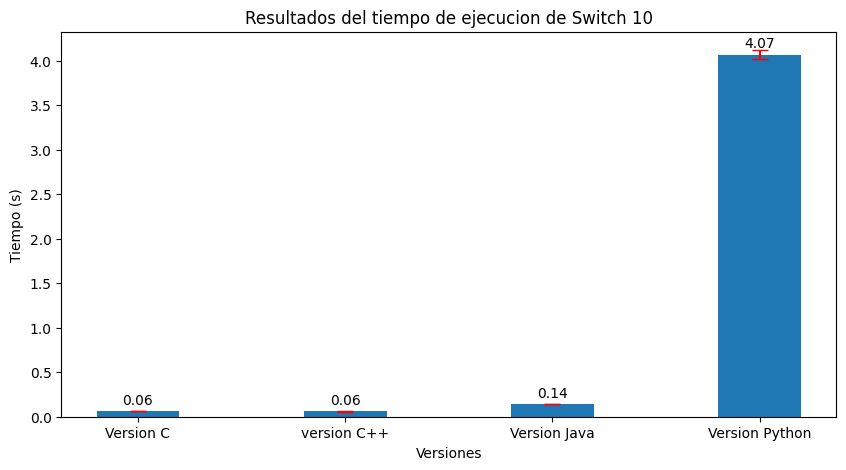

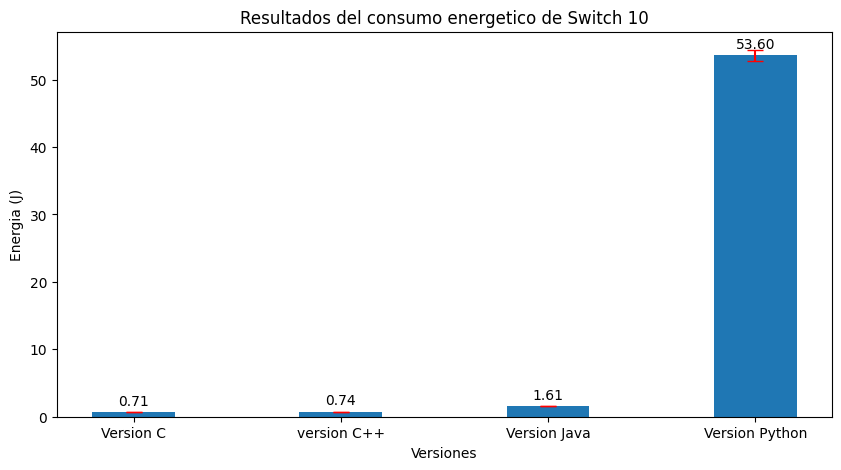

,Memoria (kB),Memoria Ratio,Tiempo (s),Tiempo Ratio,Energía (J),Energía Ratio
./switch_case_10_c,40320,1.00,0.06,1.00,0.71,1.00
./switch_case_10_cpp,42112,1.04,0.06,0.97,0.74,1.04
java -jar switch_case_10_java.jar,156348,3.88,0.14,2.34,1.61,2.25
python3 switch_case_10.py,439424,10.90,4.07,67.56,53.60,75.07


In [138]:
filename = 'build/analisis_basico/condicionales/switch_case_10/output.txt' 
parsed_data = parse_file(filename)

tableMemory(parsed_data, "Switch 10")
tablePerfStat(parsed_data, "Switch 10")
plotTime(parsed_data, "Switch 10")
plotEnergy(parsed_data, "Switch 10")
tableMetrics(parsed_data)

,Switch 1000,Memoria (kB)
0,Version C,40448
1,version C++,42112
2,Version Java,156476
3,Version Python,441728


,Switch 1000,context-switches,cycles,instructions,CPI,cache-references,cache-misses,ratio cache %,branches,branch-misses,ratio branches %
0,Version C,0.80,194486303.40,394783934.80,0.49,3647395.20,2521445.60,69.13,38572903.40,12630.40,0.03
1,version C++,3.20,195065532.20,401859684.60,0.49,3741700.40,2558277.20,68.37,39045257.40,17107.00,0.04
2,Version Java,139.80,883919533.40,1616017656.40,0.55,38201743.20,8130897.80,21.28,285256101.20,1569997.00,0.55
3,Version Python,1748.60,288132196862.80,1169759766445.20,0.25,228180656.60,59360879.40,26.01,214630741220.40,57539087.00,0.03


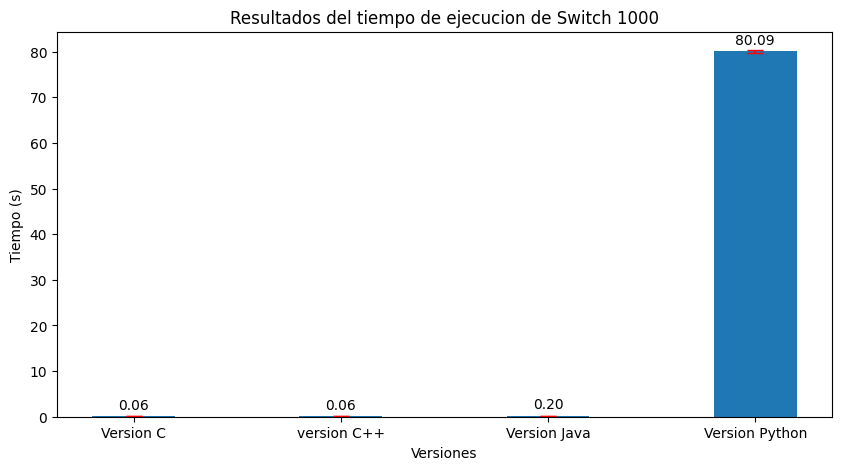

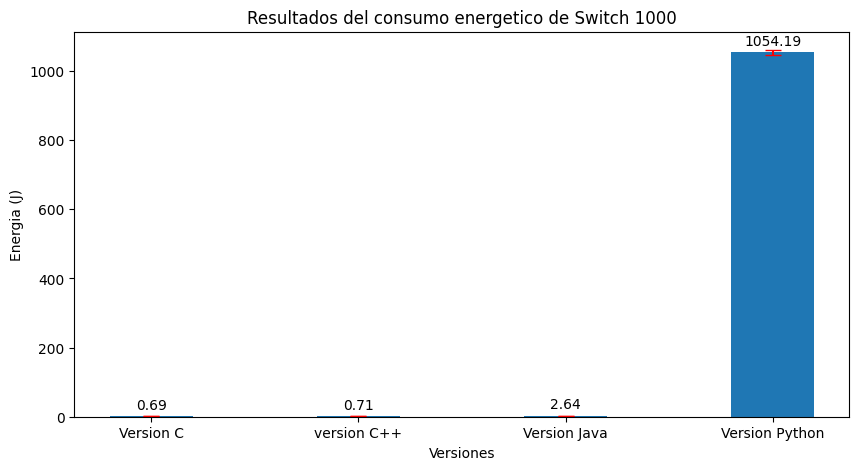

,Memoria (kB),Memoria Ratio,Tiempo (s),Tiempo Ratio,Energía (J),Energía Ratio
./switch_case_1000_c,40448,1.00,0.06,1.00,0.69,1.00
./switch_case_1000_cpp,42112,1.04,0.06,0.94,0.71,1.03
java -jar switch_case_1000_java.jar,156476,3.87,0.20,3.33,2.64,3.82
python3 switch_case_1000.py,441728,10.92,80.09,1348.72,1054.19,1523.39


In [139]:
filename = 'build/analisis_basico/condicionales/switch_case_1000/output.txt' 
parsed_data = parse_file(filename)

tableMemory(parsed_data, "Switch 1000")
tablePerfStat(parsed_data, "Switch 1000")
plotTime(parsed_data, "Switch 1000")
plotEnergy(parsed_data, "Switch 1000")
tableMetrics(parsed_data)

,Fibonacci,Memoria (kB)
0,Version C,1408
1,version C++,3328
2,Version Java,41020
3,Version Python,8320


,Fibonacci,context-switches,cycles,instructions,CPI,cache-references,cache-misses,ratio cache %,branches,branch-misses,ratio branches %
0,Version C,237.00,12149791364.80,26126524431.40,0.47,505004.80,35615.00,7.05,6045529926.60,625502.00,0.01
1,version C++,214.60,12146992486.60,26128063177.40,0.46,556004.00,65984.40,11.87,6046451282.20,554418.40,0.01
2,Version Java,222.40,6619167647.60,22189642983.20,0.30,12212032.20,1687169.60,13.82,6092208556.00,1495106.20,0.02
3,Version Python,497.00,443676547819.60,1587593188945.40,0.28,17910963.40,472330.00,2.64,285467427924.20,672004811.00,0.24


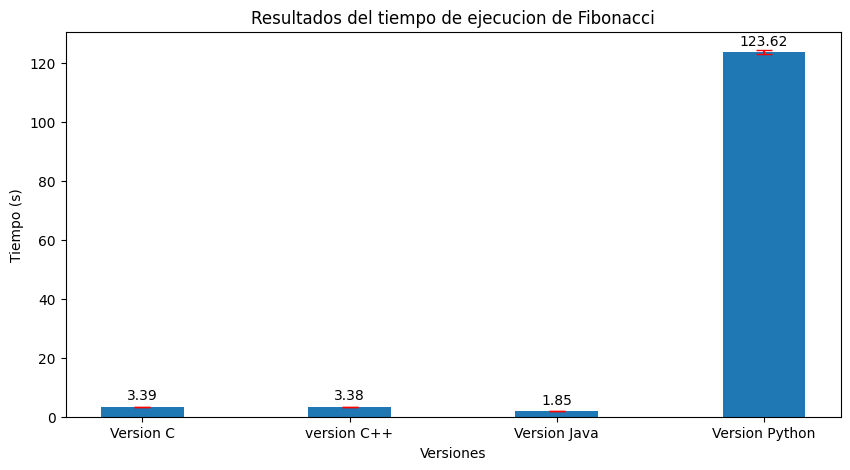

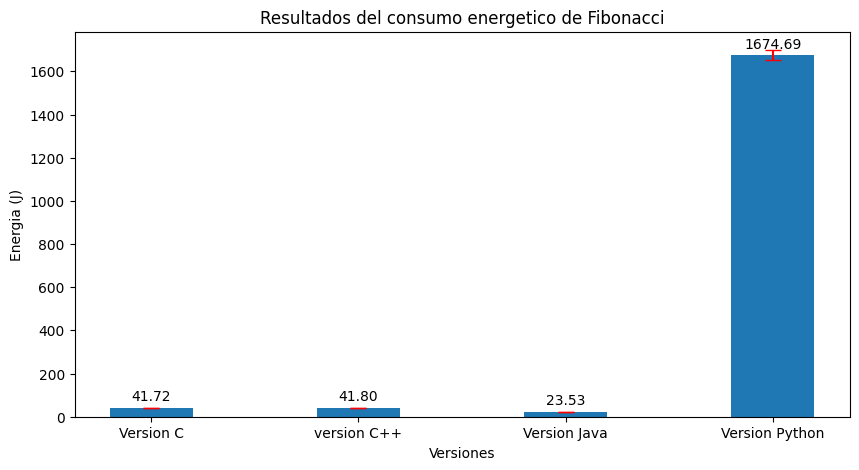

,Memoria (kB),Memoria Ratio,Tiempo (s),Tiempo Ratio,Energía (J),Energía Ratio
./fibo_c,1408,1.00,3.39,1.00,41.72,1.00
./fibo_cpp,3328,2.36,3.38,1.00,41.80,1.00
java -jar fibo_java.jar,41020,29.13,1.85,0.54,23.53,0.56
python3 fibo.py,8320,5.91,123.62,36.45,1674.69,40.14


In [140]:
filename = 'build/algoritmos/fibonacci/output.txt' 
parsed_data = parse_file(filename)

tableMemory(parsed_data, "Fibonacci")
tablePerfStat(parsed_data, "Fibonacci")
plotTime(parsed_data, "Fibonacci")
plotEnergy(parsed_data, "Fibonacci")
tableMetrics(parsed_data)

,Funcion,Memoria (kB)
0,Version C,79488
1,version C++,42240
2,Version Java,278712
3,Version Python,517376


,Funcion,context-switches,cycles,instructions,CPI,cache-references,cache-misses,ratio cache %,branches,branch-misses,ratio branches %
0,Version C,16.20,8479604602.00,13882600028.00,0.61,47827077.40,14552539.20,30.43,2455708485.80,113328843.60,4.61
1,version C++,91.80,43641600971.00,80283335340.20,0.54,30259093.80,9769668.20,32.29,13801365154.80,201781355.60,1.46
2,Version Java,754.60,6626762565.60,13904656905.20,0.48,131552241.20,33834399.80,25.72,2801951053.00,86351741.00,3.08
3,Version Python,463.20,24377706266.80,40356189086.20,0.60,1062276975.40,497422739.00,46.83,8622245164.80,122929375.00,1.43


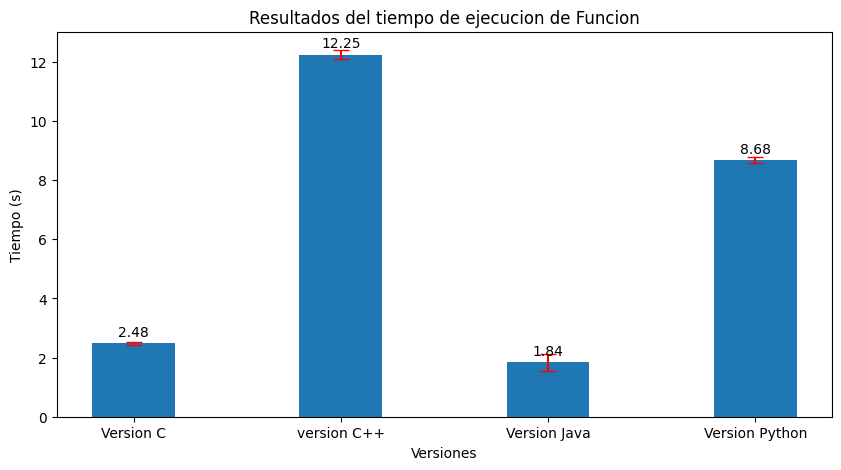

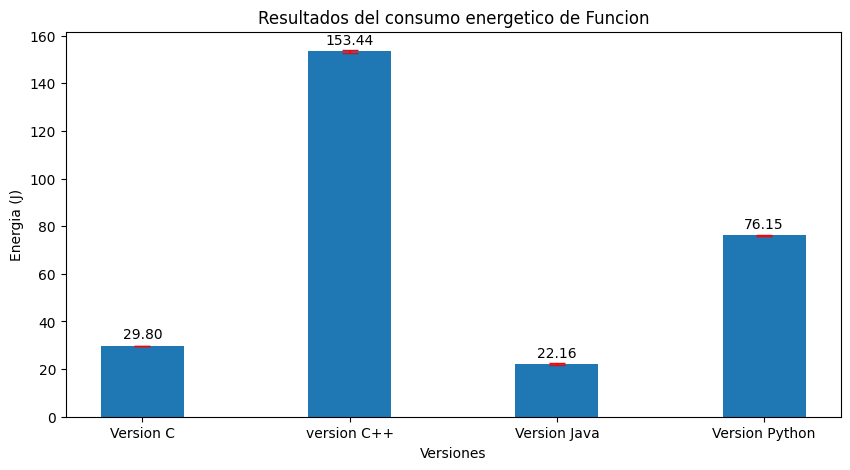

,Memoria (kB),Memoria Ratio,Tiempo (s),Tiempo Ratio,Energía (J),Energía Ratio
./orden_c,79488,1.00,2.48,1.00,29.80,1.00
./orden_cpp,42240,0.53,12.25,4.95,153.44,5.15
java -jar orden_java.jar,278712,3.51,1.84,0.74,22.16,0.74
python3 orden.py,517376,6.51,8.68,3.50,76.15,2.56


In [141]:
filename = 'build/algoritmos/orden/fun_existente/output.txt' 
parsed_data = parse_file(filename)

tableMemory(parsed_data, "Funcion")
tablePerfStat(parsed_data, "Funcion")
plotTime(parsed_data, "Funcion")
plotEnergy(parsed_data, "Funcion")
tableMetrics(parsed_data)

,Quicksort,Memoria (kB)
0,Version C,40448
1,version C++,42240
2,Version Java,277336
3,Version Python,439424


,Quicksort,context-switches,cycles,instructions,CPI,cache-references,cache-misses,ratio cache %,branches,branch-misses,ratio branches %
0,Version C,90.60,10256588196.20,17844641644.40,0.57,32739010.00,9498460.80,29.01,2499013342.60,84275569.60,3.37
1,version C++,92.60,43554247910.20,80181907978.40,0.54,37691733.00,9581773.20,25.42,13273303333.60,205335624.40,1.55
2,Version Java,737.80,6730165664.60,12411586821.80,0.54,128859986.40,34930285.60,27.11,2177222074.40,96862734.80,4.45
3,Version Python,1172.00,215570153676.60,601043615494.60,0.36,2756227060.20,1382358726.80,50.15,107980477472.40,131331629.60,0.12


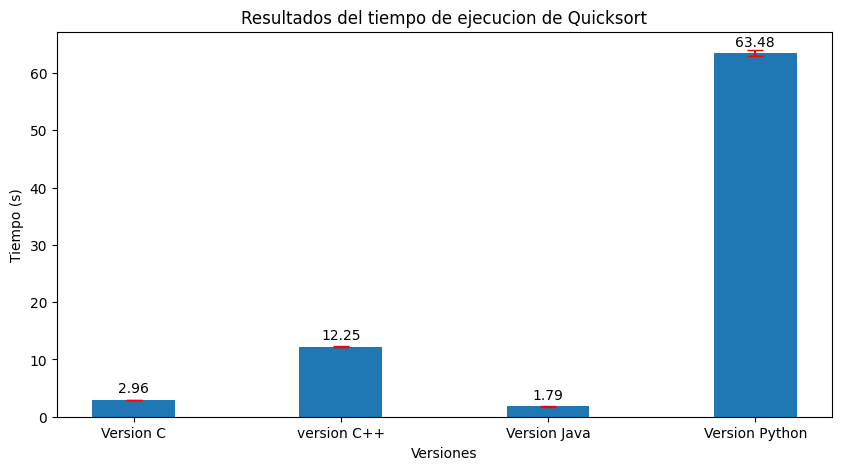

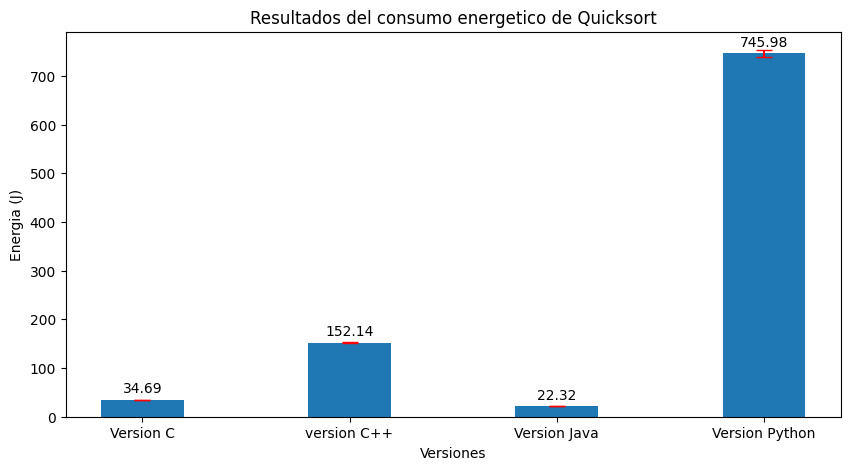

,Memoria (kB),Memoria Ratio,Tiempo (s),Tiempo Ratio,Energía (J),Energía Ratio
./quicksort_c,40448,1.00,2.96,1.00,34.69,1.00
./quicksort_cpp,42240,1.04,12.25,4.14,152.14,4.39
java -jar quicksort_java.jar,277336,6.86,1.79,0.61,22.32,0.64
python3 quicksort.py,439424,10.86,63.48,21.43,745.98,21.50


In [142]:
filename = 'build/algoritmos/orden/quicksort/output.txt' 
parsed_data = parse_file(filename)

tableMemory(parsed_data, "Quicksort")
tablePerfStat(parsed_data, "Quicksort")
plotTime(parsed_data, "Quicksort")
plotEnergy(parsed_data, "Quicksort")
tableMetrics(parsed_data)

,Timsort,Memoria (kB)
0,Version C,79508
1,version C++,81272
2,Version Java,301232
3,Version Python,508792


,Timsort,context-switches,cycles,instructions,CPI,cache-references,cache-misses,ratio cache %,branches,branch-misses,ratio branches %
0,Version C,240.20,9886625790.40,19350361370.60,0.51,77334728.60,32361086.60,41.85,2476540524.80,102104148.60,4.12
1,version C++,95.20,43179654609.80,81687829225.20,0.53,82129592.00,32876560.40,40.03,13265871364.80,221290617.40,1.67
2,Version Java,1249.00,8033606408.80,16555594990.00,0.49,200690791.40,72513882.20,36.13,3598881451.60,112982772.80,3.14
3,Version Python,1557.20,248559704564.80,736932057985.80,0.34,2850907627.40,1225698978.00,42.99,134856176103.80,186204344.00,0.14


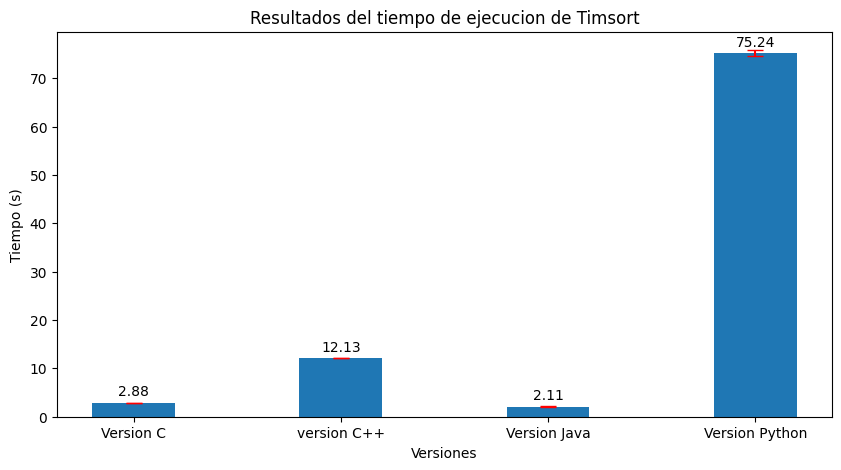

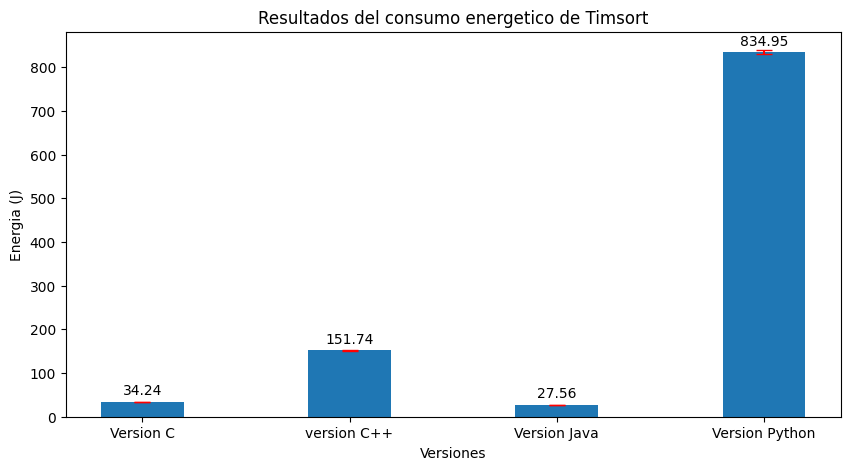

,Memoria (kB),Memoria Ratio,Tiempo (s),Tiempo Ratio,Energía (J),Energía Ratio
./timsort_c,79508,1.00,2.88,1.00,34.24,1.00
./timsort_cpp,81272,1.02,12.13,4.21,151.74,4.43
java -jar timsort_java.jar,301232,3.79,2.11,0.73,27.56,0.81
python3 timsort.py,508792,6.40,75.24,26.10,834.95,24.39


In [143]:
filename = 'build/algoritmos/orden/timsort/output.txt' 
parsed_data = parse_file(filename)

tableMemory(parsed_data, "Timsort")
tablePerfStat(parsed_data, "Timsort")
plotTime(parsed_data, "Timsort")
plotEnergy(parsed_data, "Timsort")
tableMetrics(parsed_data)

,Busqueda,Memoria (kB)
0,Version C,1792
1,version C++,4736
2,Version Java,449260
3,Version Python,11136


,Busqueda,context-switches,cycles,instructions,CPI,cache-references,cache-misses,ratio cache %,branches,branch-misses,ratio branches %
0,Version C,5.20,155814552.40,262714039.40,0.59,9981594.40,27795.60,0.28,58861744.60,22106.40,0.04
1,version C++,54.40,3432709335.40,6120876274.60,0.56,80149327.80,88479.80,0.11,939992346.80,1433029.40,0.15
2,Version Java,22900.20,1369147602875.20,6864247798479.60,0.20,237116626133.20,1057038382.20,0.45,2055084475504.60,264842415.20,0.01
3,Version Python,22.20,1221691645.60,3117542701.00,0.39,123510220.00,425546.40,0.34,690344490.60,3306835.60,0.48


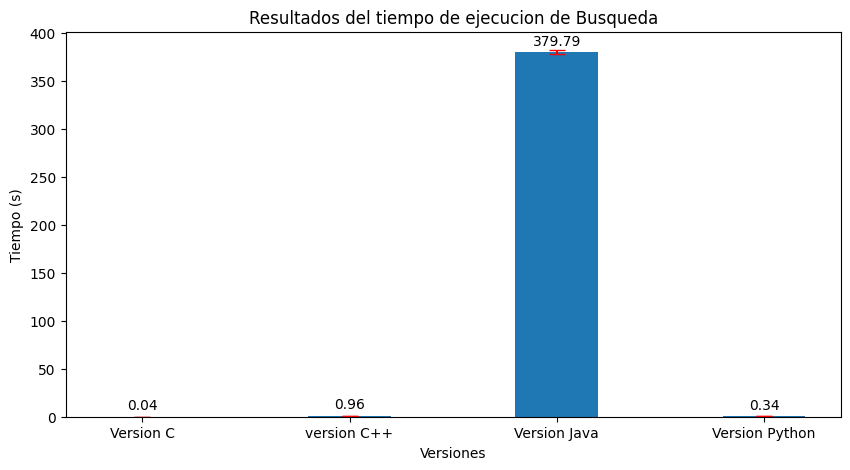

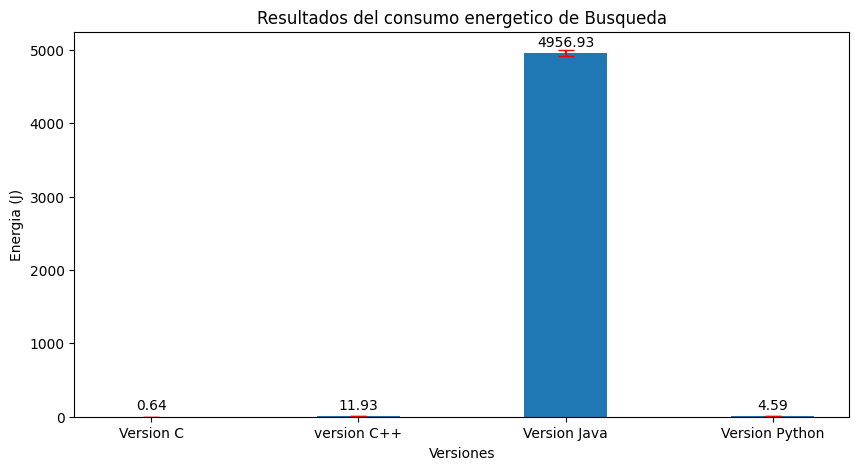

,Memoria (kB),Memoria Ratio,Tiempo (s),Tiempo Ratio,Energía (J),Energía Ratio
./bfs_c,1792,1.00,0.04,1.00,0.64,1.00
./bfs_cpp,4736,2.64,0.96,21.44,11.93,18.58
java -jar bfs_java.jar,449260,250.70,379.79,8498.72,4956.93,7721.07
python3 bfs.py,11136,6.21,0.34,7.66,4.59,7.14


In [144]:
filename = 'build/algoritmos/busqueda/output.txt' 
parsed_data = parse_file(filename)

tableMemory(parsed_data, "Busqueda")
tablePerfStat(parsed_data, "Busqueda")
plotTime(parsed_data, "Busqueda")
plotEnergy(parsed_data, "Busqueda")
tableMetrics(parsed_data)

,IMG,Memoria (kB)
0,Version C,1280
1,version C++,3328
2,Version Java,41052
3,Version Python,8192


,IMG,context-switches,cycles,instructions,CPI,cache-references,cache-misses,ratio cache %,branches,branch-misses,ratio branches %
0,Version C,32.20,15126420295.40,31207036483.20,0.48,11623015.60,5029918.20,43.28,6160297520.40,1122598.40,0.02
1,version C++,83.80,10647397204.40,37445151201.20,0.28,11220179.60,4933914.80,43.97,7329980747.20,790931.40,0.01
2,Version Java,6445.00,660284353407.40,1276690245610.60,0.52,97052437.00,6895273.80,7.10,224432303157.20,1971296331.40,0.88
3,Version Python,613.00,197783699950.20,549715237604.20,0.36,64558230.80,4938035.00,7.65,110168241877.00,321799618.80,0.29


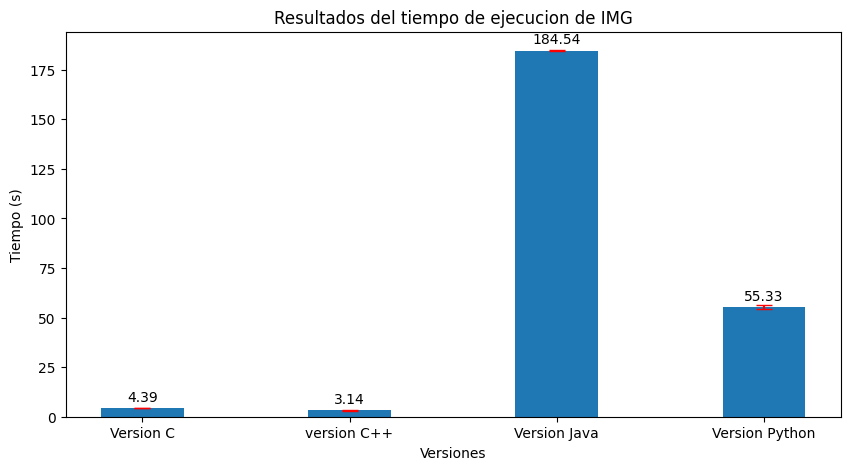

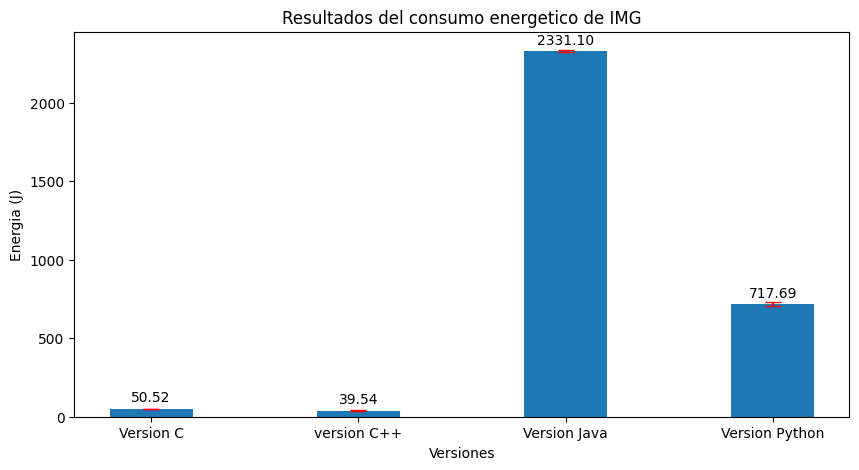

,Memoria (kB),Memoria Ratio,Tiempo (s),Tiempo Ratio,Energía (J),Energía Ratio
./aritmetica_c,1280,1.00,4.39,1.00,50.52,1.00
./aritmetica_cpp,3328,2.60,3.14,0.72,39.54,0.78
java -jar aritmetica_java.jar,41052,32.07,184.54,42.06,2331.10,46.14
python3 aritmetica.py,8192,6.40,55.33,12.61,717.69,14.20


In [145]:
filename = 'build/img_bmp/aritmetica/aritmetica_sin_buffer/output.txt' 
parsed_data = parse_file(filename)

tableMemory(parsed_data, "IMG")
tablePerfStat(parsed_data, "IMG")
plotTime(parsed_data, "IMG")
plotEnergy(parsed_data, "IMG")
tableMetrics(parsed_data)

,IMG buffer,Memoria (kB)
0,Version C,188800
1,version C++,190720
2,Version Java,417852
3,Version Python,195968


,IMG buffer,context-switches,cycles,instructions,CPI,cache-references,cache-misses,ratio cache %,branches,branch-misses,ratio branches %
0,Version C,33.20,1658912217.00,4296775668.00,0.39,17986369.00,12016463.20,66.81,236389143.40,262759.40,0.11
1,version C++,31.20,1668460444.80,4303661515.20,0.39,17738275.60,11672523.20,65.80,237152780.20,286027.60,0.12
2,Version Java,247.60,2420836006.80,2358563102.00,1.03,45339465.60,25661659.00,56.60,342905425.60,1383134.40,0.40
3,Version Python,315.80,108322477513.20,334545549408.00,0.32,31506502.60,16626184.80,52.77,65351204942.80,193659399.20,0.30


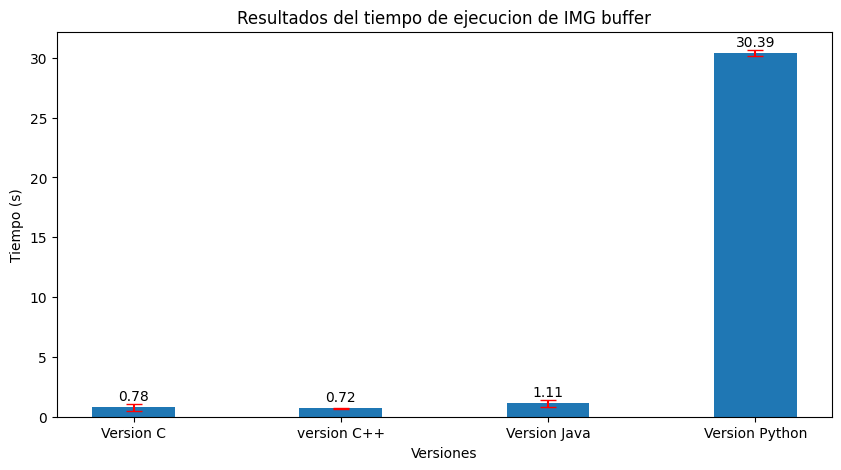

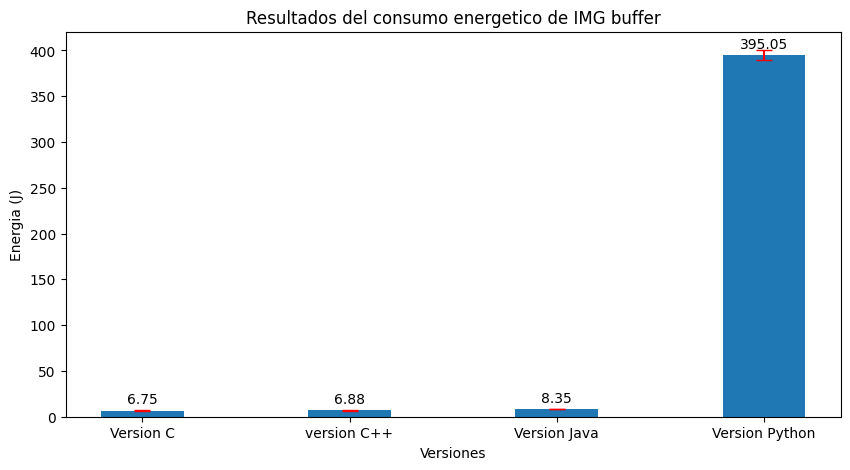

,Memoria (kB),Memoria Ratio,Tiempo (s),Tiempo Ratio,Energía (J),Energía Ratio
./aritmetica_buffer_c,188800,1.00,0.78,1.00,6.75,1.00
./aritmetica_buffer_cpp,190720,1.01,0.72,0.93,6.88,1.02
java -jar aritmetica_buffer_java.jar,417852,2.21,1.11,1.43,8.35,1.24
python3 aritmetica_buffer.py,195968,1.04,30.39,39.08,395.05,58.53


In [146]:
filename = 'build/img_bmp/aritmetica/aritmetica_con_buffer/output.txt' 
parsed_data = parse_file(filename)

tableMemory(parsed_data, "IMG buffer")
tablePerfStat(parsed_data, "IMG buffer")
plotTime(parsed_data, "IMG buffer")
plotEnergy(parsed_data, "IMG buffer")
tableMetrics(parsed_data)

,IMG hilos,Memoria (kB)
0,Version C,189056
1,version C++,190976
2,Version Java,416572
3,Version Python,196736


,IMG hilos,context-switches,cycles,instructions,CPI,cache-references,cache-misses,ratio cache %,branches,branch-misses,ratio branches %
0,Version C,26.20,1699988567.40,4466623937.80,0.38,19748146.40,12207002.00,61.81,236938311.00,282374.40,0.12
1,version C++,28.00,1686192572.80,4443690461.20,0.38,19976758.80,11863682.40,59.39,238693944.40,282485.00,0.12
2,Version Java,249.00,2610785078.60,3097141451.60,0.84,54131065.20,26044400.40,48.11,580915174.60,1086549.40,0.19
3,Version Python,31838.20,119115814490.80,357779779897.60,0.33,128598151.40,16950031.00,13.18,69844585910.60,326226836.40,0.47


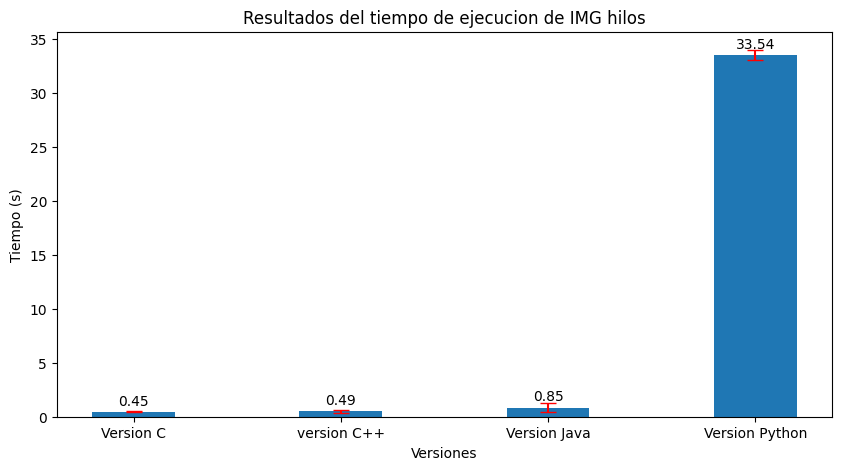

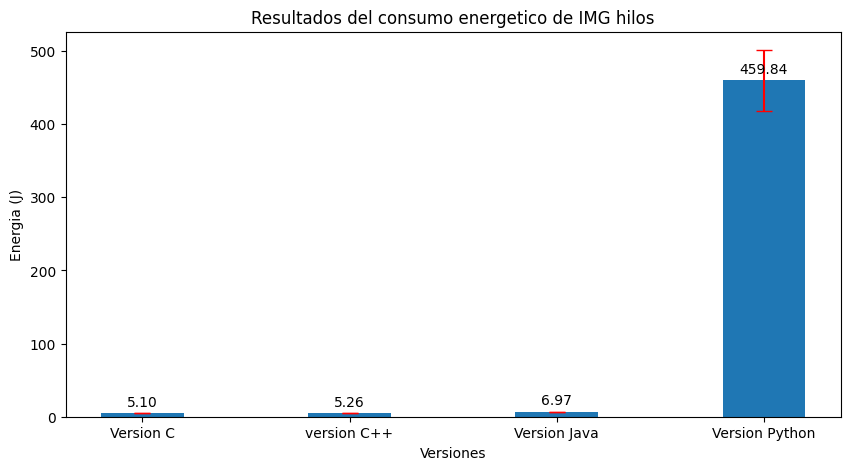

,Memoria (kB),Memoria Ratio,Tiempo (s),Tiempo Ratio,Energía (J),Energía Ratio
./aritmetica_hilos_c,189056,1.00,0.45,1.00,5.10,1.00
./aritmetica_hilos_cpp,190976,1.01,0.49,1.10,5.26,1.03
java -jar aritmetica_hilos_java.jar,416572,2.20,0.85,1.89,6.97,1.36
python3 aritmetica_hilos.py,196736,1.04,33.54,74.64,459.84,90.09


In [147]:
filename = 'build/img_bmp/aritmetica/aritmetica_hilos_buffer/output.txt' 
parsed_data = parse_file(filename)

tableMemory(parsed_data, "IMG hilos")
tablePerfStat(parsed_data, "IMG hilos")
plotTime(parsed_data, "IMG hilos")
plotEnergy(parsed_data, "IMG hilos")
tableMetrics(parsed_data)

,Mandel,Memoria (kB)
0,Version C,106752
1,version C++,108416
2,Version Java,263868
3,Version Python,219648


,Mandel,context-switches,cycles,instructions,CPI,cache-references,cache-misses,ratio cache %,branches,branch-misses,ratio branches %
0,Version C,157.40,89417906069.60,97747014664.00,0.91,12485277.60,7138549.20,57.18,6745461883.60,9712209.40,0.14
1,version C++,208.20,89372192476.20,97758660820.40,0.91,14462492.00,7015822.60,48.51,6743774141.80,8296967.20,0.12
2,Version Java,1124.60,43245458092.00,45931895441.40,0.94,31825335.20,15509231.00,48.73,6734284758.60,9043825.00,0.13
3,Version Python,4075.00,2462703891277.60,8305652704106.00,0.30,114220674.80,14614579.60,12.80,1534199041391.20,464299961.80,0.03


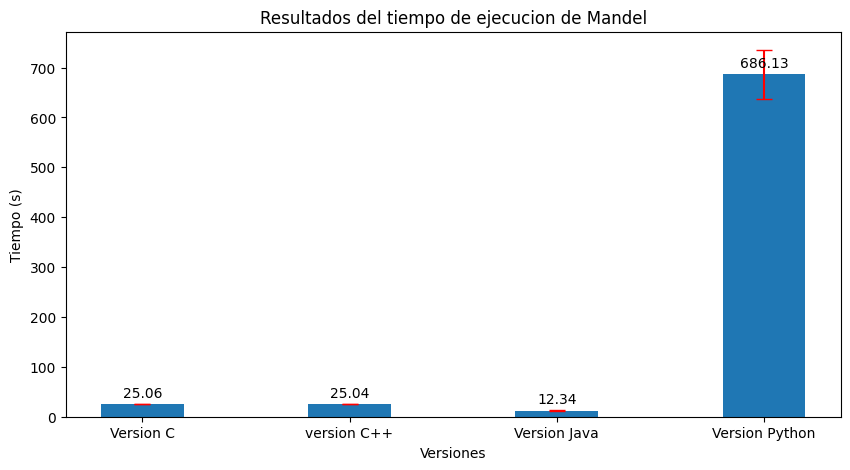

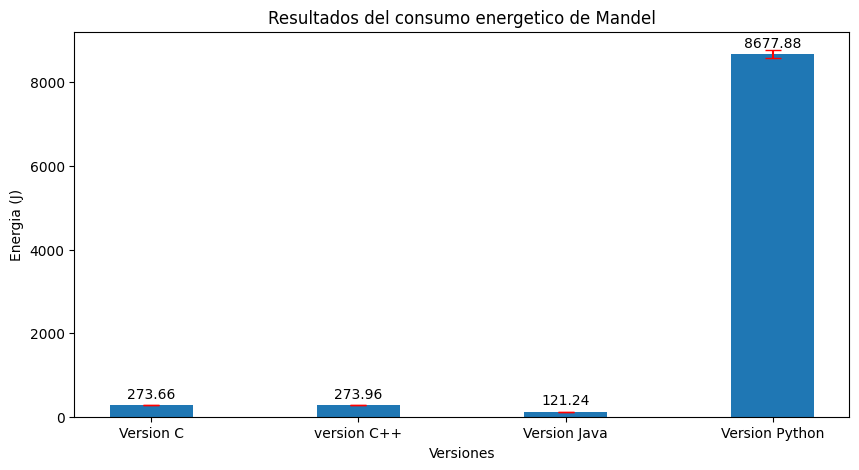

,Memoria (kB),Memoria Ratio,Tiempo (s),Tiempo Ratio,Energía (J),Energía Ratio
./mandel_c,106752,1.00,25.06,1.00,273.66,1.00
./mandel_cpp,108416,1.02,25.04,1.00,273.96,1.00
java -jar mandel_java.jar,263868,2.47,12.34,0.49,121.24,0.44
python3 mandel.py,219648,2.06,686.13,27.38,8677.88,31.71


In [148]:
filename = 'build/img_bmp/mandel/mandel_simple/output.txt' 
parsed_data = parse_file(filename)

tableMemory(parsed_data, "Mandel")
tablePerfStat(parsed_data, "Mandel")
plotTime(parsed_data, "Mandel")
plotEnergy(parsed_data, "Mandel")
tableMetrics(parsed_data)

,Mandel hilos,Memoria (kB)
0,Version C,106624
1,version C++,108416
2,Version Java,251964
3,Version Python,220288


,Mandel hilos,context-switches,cycles,instructions,CPI,cache-references,cache-misses,ratio cache %,branches,branch-misses,ratio branches %
0,Version C,373.00,89303543181.60,97748280479.40,0.91,14172324.20,6993791.20,49.35,6744950355.00,7998841.00,0.12
1,version C++,709.60,89331448872.00,97759337353.00,0.91,16133620.00,6898761.00,42.76,6746962265.20,8038050.00,0.12
2,Version Java,490.80,43656602532.60,44579937871.60,0.98,35104897.60,15496544.20,44.14,4422316280.00,8618017.20,0.19
3,Version Python,251908.00,2382063348763.60,8309777410814.00,0.29,1501518108.80,14474526.00,0.96,1535526079971.60,350183320.20,0.02


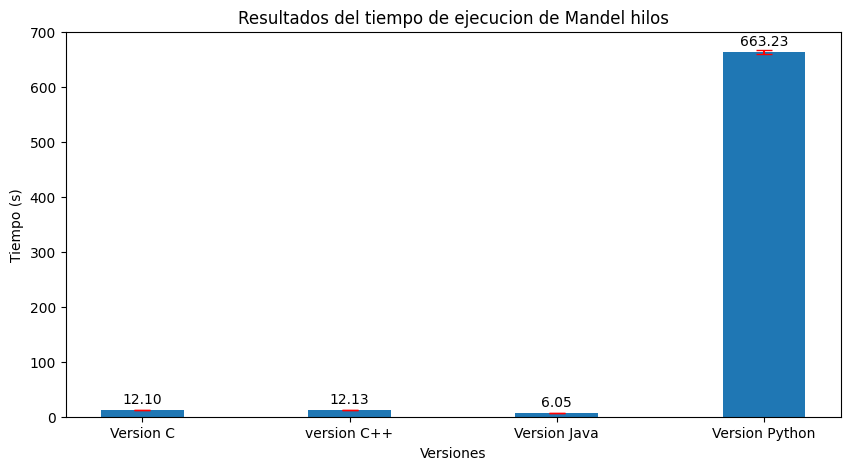

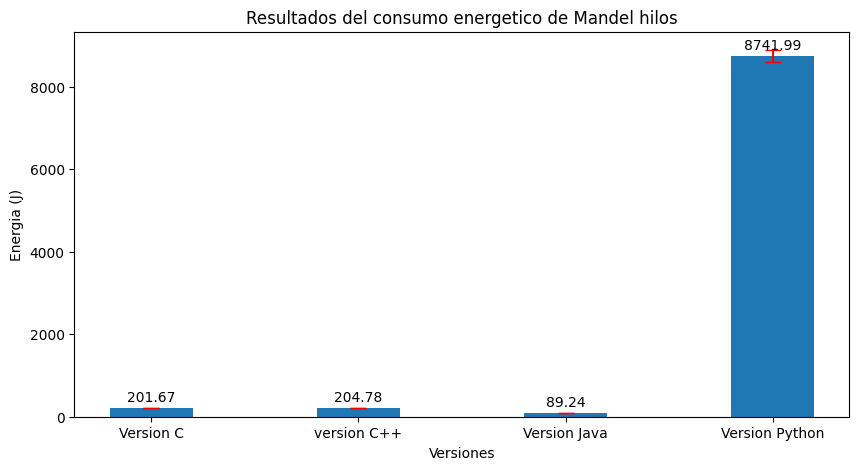

,Memoria (kB),Memoria Ratio,Tiempo (s),Tiempo Ratio,Energía (J),Energía Ratio
./mandel_hilos_c,106624,1.00,12.10,1.00,201.67,1.00
./mandel_hilos_cpp,108416,1.02,12.13,1.00,204.78,1.02
java -jar mandel_hilos_java.jar,251964,2.36,6.05,0.50,89.24,0.44
python3 mandel_hilos.py,220288,2.07,663.23,54.80,8741.99,43.35


In [149]:
filename = 'build/img_bmp/mandel/mandel_hilos/output.txt' 
parsed_data = parse_file(filename)

tableMemory(parsed_data, "Mandel hilos")
tablePerfStat(parsed_data, "Mandel hilos")
plotTime(parsed_data, "Mandel hilos")
plotEnergy(parsed_data, "Mandel hilos")
tableMetrics(parsed_data)

,Mandel CUDA,Memoria (kB)
0,Version C,209832
1,version C++,211360
2,Version Java,351804
3,Version Python,244972


,Mandel CUDA,context-switches,cycles,instructions,CPI,cache-references,cache-misses,ratio cache %,branches,branch-misses,ratio branches %
0,Version C,69.80,3031513336.80,5067620078.00,0.60,28781696.20,15885438.80,55.19,927686088.40,477670.20,0.05
1,version C++,76.60,3042628682.60,5185516131.40,0.59,28862498.60,15777014.20,54.66,950218399.60,522937.20,0.06
2,Version Java,243.40,3465629168.80,5594019878.60,0.62,50901922.00,26593563.60,52.24,1016791285.00,1243490.20,0.12
3,Version Python,173.80,7555149044.40,9808489888.20,0.77,51367257.40,17827898.40,34.71,1791088785.20,4895695.80,0.27


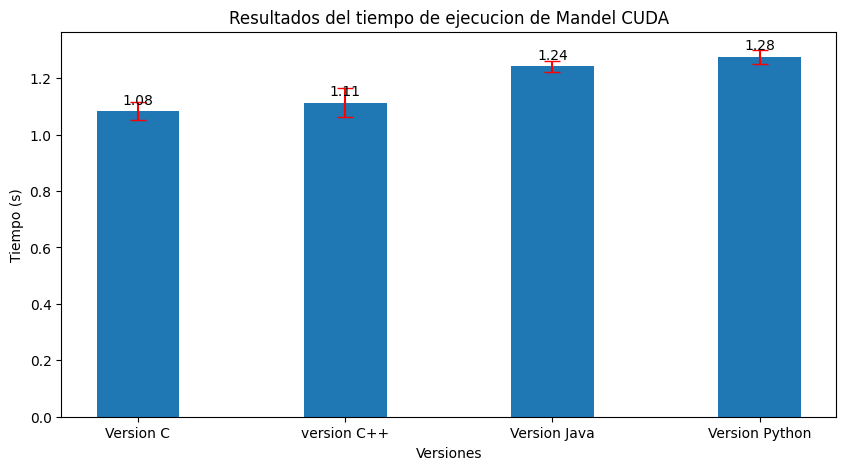

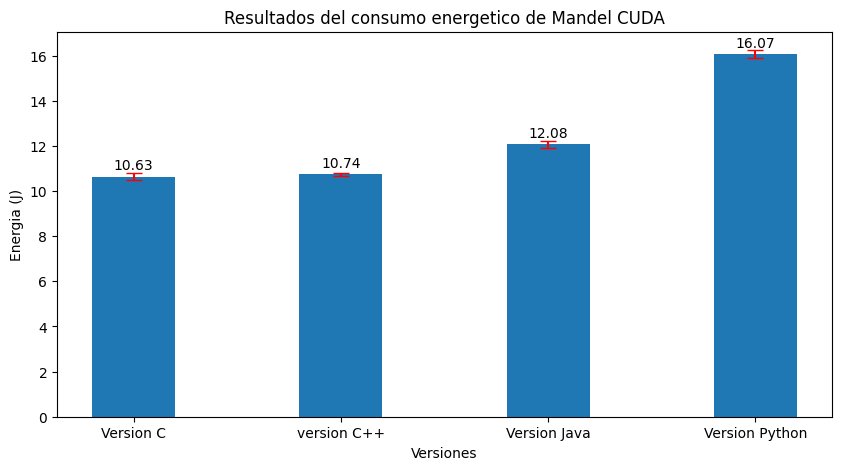

,Memoria (kB),Memoria Ratio,Tiempo (s),Tiempo Ratio,Energía (J),Energía Ratio
./mandel_cuda_c,209832,1.00,1.08,1.00,10.63,1.00
./mandel_cuda_cpp,211360,1.01,1.11,1.03,10.74,1.01
java -jar mandel_cuda_java.jar,351804,1.68,1.24,1.15,12.08,1.14
python3 mandel_cuda.py,244972,1.17,1.28,1.18,16.07,1.51


In [150]:
filename = 'build/img_bmp/mandel/mandel_cuda/output.txt' 
parsed_data = parse_file(filename)

tableMemory(parsed_data, "Mandel CUDA")
tablePerfStat(parsed_data, "Mandel CUDA")
plotTime(parsed_data, "Mandel CUDA")
plotEnergy(parsed_data, "Mandel CUDA")
tableMetrics(parsed_data)